## Import Library

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
from PIL import Image
import cv2
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
!pip install split-folders

In [3]:
import splitfolders

## Data Loading

In [4]:
! pip install kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! pwd

/content


In [8]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download guy007/nutrientdeficiencysymptomsinrice

 99% 978M/989M [00:07<00:00, 105MB/s]
100% 989M/989M [00:07<00:00, 142MB/s]


In [10]:
! unzip nutrientdeficiencysymptomsinrice

Archive:  nutrientdeficiencysymptomsinrice.zip
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-1.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-10.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-100.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-101.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-102.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-103.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-104.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-105.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-106.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-107.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-108.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-109.JPG  
  inflating: rice_plant_lacks_nutrients/Nitrogen(N)/untitled-11.JPG  
  inflating: rice_plant_lacks_nutr

## Data Preprocessing

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/rice_plant_lacks_nutrients", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False) # default values
#splitfolders.fixed("/content/rice_plant_lacks_nutrients", output="output", seed=1337, fixed=(50, 50), oversample=True, group_prefix=None, move=False)

Copying files: 1156 files [00:04, 234.89 files/s]


## Exploratory Data Analysis

In [13]:
# Folder location
data_dir = pathlib.Path('/content/output/train')
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

In [14]:
# Show classes
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['Nitrogen(N)' 'Phosphorus(P)' 'Potassium(K)']


In [15]:
# Show total data in folder
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output/val
0 folder and 76 images in output/val/Potassium(K)
0 folder and 88 images in output/val/Nitrogen(N)
0 folder and 66 images in output/val/Phosphorus(P)
3 folder and 0 images in output/test
0 folder and 20 images in output/test/Potassium(K)
0 folder and 22 images in output/test/Nitrogen(N)
0 folder and 18 images in output/test/Phosphorus(P)
3 folder and 0 images in output/train
0 folder and 287 images in output/train/Potassium(K)
0 folder and 330 images in output/train/Nitrogen(N)
0 folder and 249 images in output/train/Phosphorus(P)


In [16]:
# Function for showing image sources
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (338, 3976, 3)


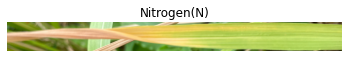

Image Shape : (3919, 272, 3)


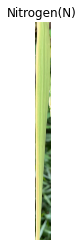

Image Shape : (4025, 359, 3)


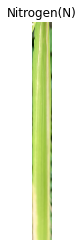

Image Shape : (4029, 323, 3)


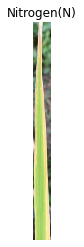

Image Shape : (4012, 298, 3)


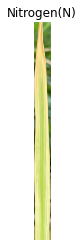

In [17]:
# Show image for classes 'Nitrogen(N)'
for i in range(1,6):
    img_n = view_random_image(target_dir='output/train/', target_class='Nitrogen(N)')

Image Shape : (3879, 415, 3)


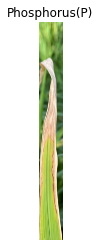

Image Shape : (3634, 400, 3)


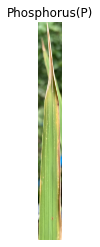

Image Shape : (3940, 349, 3)


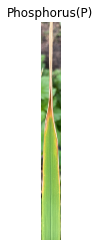

Image Shape : (383, 3985, 3)


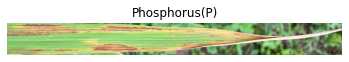

Image Shape : (4004, 376, 3)


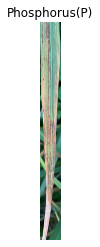

In [18]:
# Show image for classes 'Phosphorus(P)'
for i in range(1,6):
    img_n = view_random_image(target_dir='output/train/', target_class='Phosphorus(P)')

Image Shape : (2660, 430, 3)


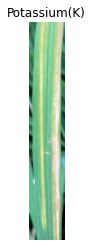

Image Shape : (326, 2574, 3)


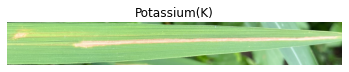

Image Shape : (3987, 421, 3)


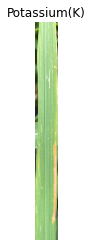

Image Shape : (2661, 464, 3)


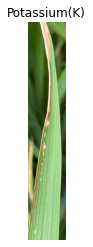

Image Shape : (2744, 376, 3)


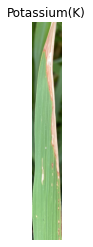

In [19]:
# Show image for classes 'Potassium(K)'
for i in range(1,6):
    img_n = view_random_image(target_dir='output/train/', target_class='Potassium(K)')

## Feature Engineering

In [20]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

### Pipeline

In [21]:
# flow from directory using datagen (Pipeline)
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 866 images belonging to 3 classes.
Found 230 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [22]:
# Check class_indices
label_indices = train_data.class_indices
label_indices

{'Nitrogen(N)': 0, 'Phosphorus(P)': 1, 'Potassium(K)': 2}

In [23]:
# Set labels
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [24]:
# Check shapes of labels
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (866,)
val_y.shape:  (230,)
test_y.shape:  (60,)


## Modelling

In [25]:
# Model Definition
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

29097984/29084464 [==============================] - 0s 0us/step


In [26]:
# Model Preparation
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [27]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                             

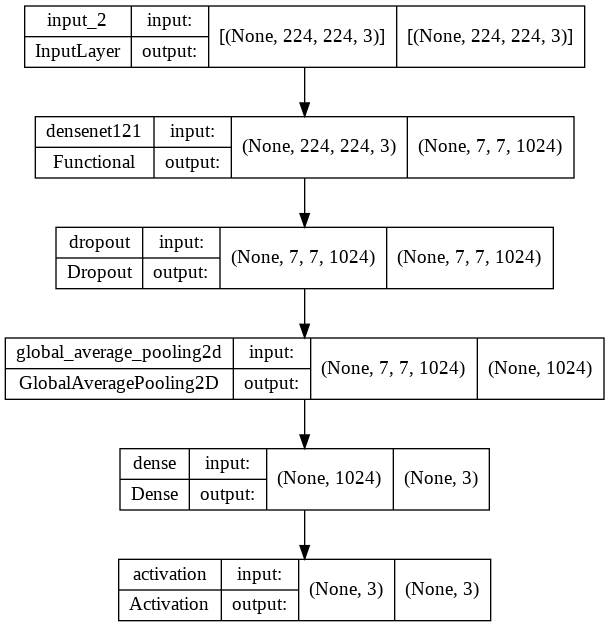

In [28]:
# Plot of Model Summary
plot_model(model, show_shapes=True)

In [29]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
initial_epochs = 15
history = model.fit(train_data, epochs=initial_epochs, validation_data=valid_data)

Epoch 1/15
55/55 [==============================] - 74s 1s/step - loss: 1.0693 - accuracy: 0.4931 - val_loss: 0.7981 - val_accuracy: 0.6565
Epoch 2/15
55/55 [==============================] - 52s 949ms/step - loss: 0.6738 - accuracy: 0.7494 - val_loss: 0.5520 - val_accuracy: 0.8043
Epoch 3/15
55/55 [==============================] - 51s 938ms/step - loss: 0.5182 - accuracy: 0.8233 - val_loss: 0.4650 - val_accuracy: 0.8261
Epoch 4/15
55/55 [==============================] - 52s 940ms/step - loss: 0.4413 - accuracy: 0.8614 - val_loss: 0.4129 - val_accuracy: 0.8652
Epoch 5/15
55/55 [==============================] - 52s 951ms/step - loss: 0.3819 - accuracy: 0.8822 - val_loss: 0.3532 - val_accuracy: 0.8957
Epoch 6/15
55/55 [==============================] - 51s 926ms/step - loss: 0.3370 - accuracy: 0.8915 - val_loss: 0.3231 - val_accuracy: 0.8913
Epoch 7/15
55/55 [==============================] - 49s 889ms/step - loss: 0.2990 - accuracy: 0.8995 - val_loss: 0.3021 - val_accuracy: 0.8870
Ep

## Model Evaluation

In [30]:
# Function for showing plot of model
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

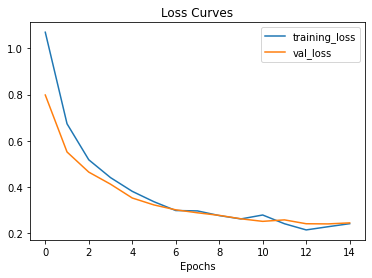

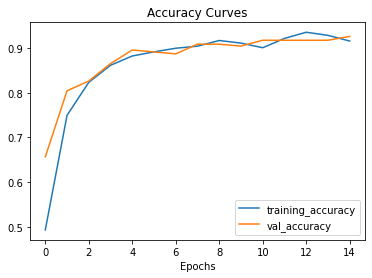

In [31]:
# Show the plot of model
plot_loss_curves(history)

In [32]:
# Evaluation
model.evaluate(valid_data)

15/15 [==============================] - 9s 585ms/step - loss: 0.2457 - accuracy: 0.9261


[0.24567562341690063, 0.926086962223053]

In [33]:
# classification report
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        81
           1       0.89      0.92      0.91        64
           2       0.97      0.87      0.92        85

    accuracy                           0.93       230
   macro avg       0.93      0.93      0.92       230
weighted avg       0.93      0.93      0.93       230



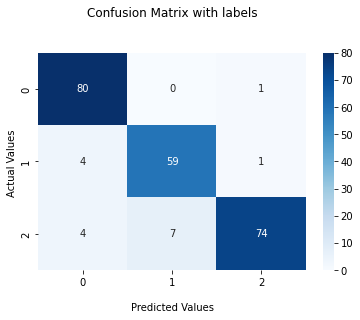

In [34]:
# confusion matrix
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## Model Inference using Test Data

In [35]:
# classification report
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20
           2       0.95      0.95      0.95        20

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



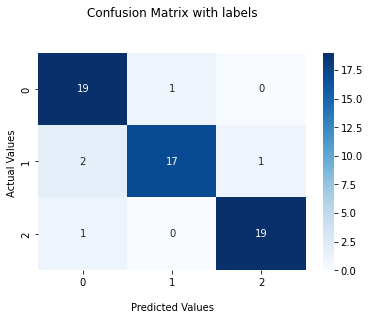

In [36]:
# confusion matrix
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## Model Inference using Custom Data

### Nitrogen (N)

#### First Image

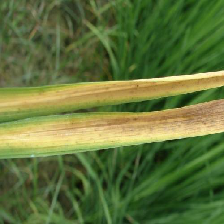

In [37]:
# Load image
n1 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/N-1.jpg", target_size=(224, 224))
n1

In [38]:
# Convert Image and Prediction
n1_arr = tf.keras.preprocessing.image.img_to_array(n1)
n1_arr = np.array([n1_arr])  # Convert single image to a batch.
n1_arr = n1_arr.astype('float32') / 255
n1_pred = model.predict(n1_arr).argmax(axis=1)
n1_pred_res = []
for i,j in label_indices.items():
  if n1_pred==j:
    n1_pred_res.append(i)

n1_pred_res

['Potassium(K)']

#### Second Image

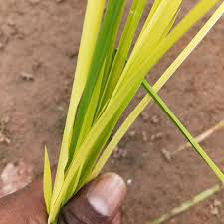

In [39]:
# Load image
n2 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/N-2.jpg", target_size=(224, 224))
n2

In [40]:
# Convert Image and Prediction
n2_arr = tf.keras.preprocessing.image.img_to_array(n2)
n2_arr = np.array([n2_arr])  # Convert single image to a batch.
n2_arr = n2_arr.astype('float32') / 255
n2_pred = model.predict(n2_arr).argmax(axis=1)
n2_pred_res = []
for i,j in label_indices.items():
  if n2_pred==j:
    n2_pred_res.append(i)

n2_pred_res

['Nitrogen(N)']

#### Third Image

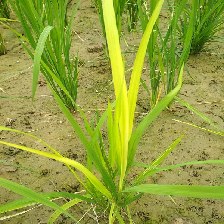

In [41]:
# Load image
n3 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/N-3.jpg", target_size=(224, 224))
n3

In [42]:
# Convert Image and Prediction
n3_arr = tf.keras.preprocessing.image.img_to_array(n3)
n3_arr = np.array([n3_arr])  # Convert single image to a batch.
n3_arr = n3_arr.astype('float32') / 255
n3_pred = model.predict(n3_arr).argmax(axis=1)
n3_pred_res = []
for i,j in label_indices.items():
  if n3_pred==j:
    n3_pred_res.append(i)

n3_pred_res

['Nitrogen(N)']

### Phosphorus (P)

#### First Image

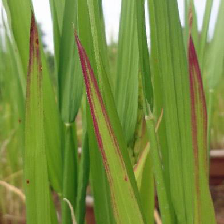

In [43]:
# Load image
p1 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/P-1.jpg", target_size=(224, 224))
p1

In [44]:
# Convert Image and Prediction
p1_arr = tf.keras.preprocessing.image.img_to_array(p1)
p1_arr = np.array([p1_arr])  # Convert single image to a batch.
p1_arr = p1_arr.astype('float32') / 255
p1_pred = model.predict(p1_arr).argmax(axis=1)
p1_pred_res = []
for i,j in label_indices.items():
  if p1_pred==j:
    p1_pred_res.append(i)

p1_pred_res

['Phosphorus(P)']

#### Second Image

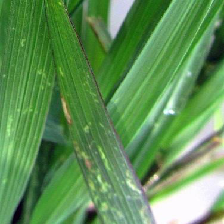

In [45]:
# Load image
p2 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/P-2.jpg", target_size=(224, 224))
p2

In [46]:
# Convert Image and Prediction
p2_arr = tf.keras.preprocessing.image.img_to_array(p2)
p2_arr = np.array([p2_arr])  # Convert single image to a batch.
p2_arr = p2_arr.astype('float32') / 255
p2_pred = model.predict(p2_arr).argmax(axis=1)
p2_pred_res = []
for i,j in label_indices.items():
  if p2_pred==j:
    p2_pred_res.append(i)

p2_pred_res

['Potassium(K)']

#### Third Image

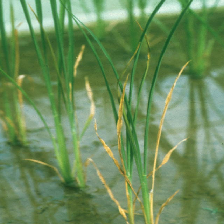

In [47]:
# Load image
p3 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/P-3.jpg", target_size=(224, 224))
p3

In [48]:
# Convert Image and Prediction
p3_arr = tf.keras.preprocessing.image.img_to_array(p3)
p3_arr = np.array([p3_arr])  # Convert single image to a batch.
p3_arr = p3_arr.astype('float32') / 255
p3_pred = model.predict(p3_arr).argmax(axis=1)
p3_pred_res = []
for i,j in label_indices.items():
  if p3_pred==j:
    p3_pred_res.append(i)

p3_pred_res

['Potassium(K)']

### Potassium (K)

#### First Image

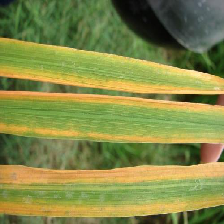

In [49]:
# Load image
k1 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/K-1.jpg", target_size=(224, 224))
k1

In [50]:
# Convert Image and Prediction
k1_arr = tf.keras.preprocessing.image.img_to_array(k1)
k1_arr = np.array([k1_arr])  # Convert single image to a batch.
k1_arr = k1_arr.astype('float32') / 255
k1_pred = model.predict(k1_arr).argmax(axis=1)
k1_pred_res = []
for i,j in label_indices.items():
  if k1_pred==j:
    k1_pred_res.append(i)

k1_pred_res

['Potassium(K)']

#### Second Image

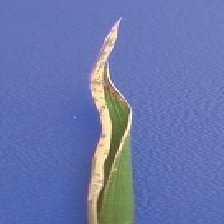

In [51]:
# Load image
k2 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/K-2.jpg", target_size=(224, 224))
k2

In [52]:
# Convert Image and Prediction
k2_arr = tf.keras.preprocessing.image.img_to_array(k2)
k2_arr = np.array([k2_arr])  # Convert single image to a batch.
k2_arr = k2_arr.astype('float32') / 255
k2_pred = model.predict(k2_arr).argmax(axis=1)
k2_pred_res = []
for i,j in label_indices.items():
  if k2_pred==j:
    k2_pred_res.append(i)

k2_pred_res

['Potassium(K)']

#### Third Image

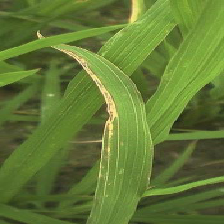

In [53]:
# Load image
k3 = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/K-3.jpg", target_size=(224, 224))
k3

In [54]:
# Convert Image and Prediction
k3_arr = tf.keras.preprocessing.image.img_to_array(k3)
k3_arr = np.array([k3_arr])  # Convert single image to a batch.
k3_arr = k3_arr.astype('float32') / 255
k3_pred = model.predict(k3_arr).argmax(axis=1)
k3_pred_res = []
for i,j in label_indices.items():
  if k3_pred==j:
    k3_pred_res.append(i)

k3_pred_res

['Potassium(K)']

### Model Saving

In [55]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [56]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 92%)
  adding: content/model/keras_metadata.pb (deflated 96%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 78%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 7%)
